In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path

In [19]:
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

In [45]:
root_dir = Path.cwd()
result_dir = root_dir / "res"

In [20]:
from rolling_sequence import finishing_pass_design_1, finishing_pass_design_2, finishing_pass_design_3, \
    finishing_pass_design_4
from utilities import *

In [21]:
pass_design_1 = finishing_pass_design_1(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
pass_design_2 = finishing_pass_design_2(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
pass_design_3 = finishing_pass_design_3(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
pass_design_4 = finishing_pass_design_4(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)

In [22]:
def calculate_wear_areas():
    sequences = [
        {"label": "RPD1", "sequence": pass_design_1},
        {"label": "RPD2", "sequence": pass_design_2},
        {"label": "RPD3", "sequence": pass_design_3},
        #{"label": "RPD4", "sequence": pass_design_3}
    ]

    wear_areas = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label:
                        wear_area = calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour,
                                                                    True, {"measurement_id": measurement_id,
                                                                           "label": roll_pass.label})
                        normed_wear_area = wear_area / roll_pass.roll.groove.cross_section.area
                        wear_areas.append({
                            "groove": groove_label,
                            "measurement_id": measurement_id,
                            "label": label,
                            "tonnage": tonnage,
                            "wear_area": wear_area,
                            "normed_wear_area": normed_wear_area
                        })

    return wear_areas

In [ ]:
wear_areas = calculate_wear_areas()

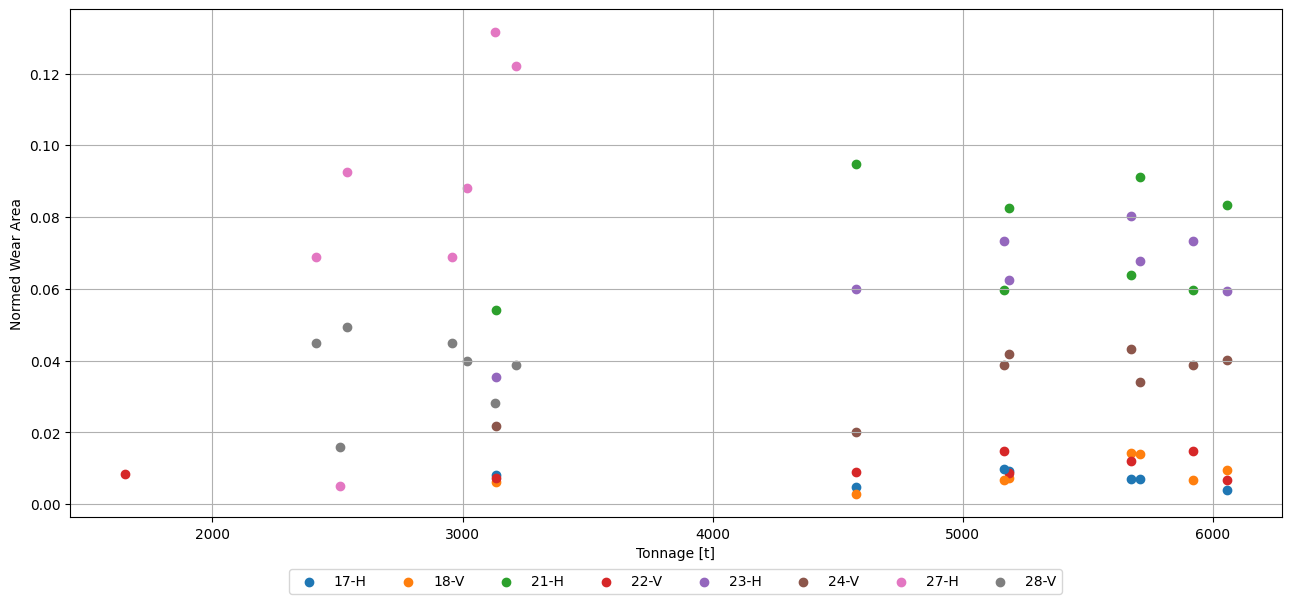

In [46]:
label_colors = {}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, label in enumerate(sorted(set(d['label'] for d in wear_areas))):
    label_colors[label] = color_cycle[i % len(color_cycle)]

fig: plt.Figure = plt.figure(figsize=(12.8, 6), layout="constrained")
ax: plt.Axes
axl: plt.Axes
ax, axl = fig.subplots(nrows=2, height_ratios=[1, 0.05])
ax.set_ylabel('Normed Wear Area')
ax.grid()
ax.set_xlabel('Tonnage [t]')
for wear_dicts in wear_areas:
    ax.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color=label_colors[wear_dicts['label']],
               label=wear_dicts['label'])

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

axl.axis("off")
axl.legend(by_label.values(), by_label.keys(), ncols=8, loc="lower center")

fig.savefig(result_dir / "wear_area_measurements.pdf",dpi=300, bbox_inches="tight")

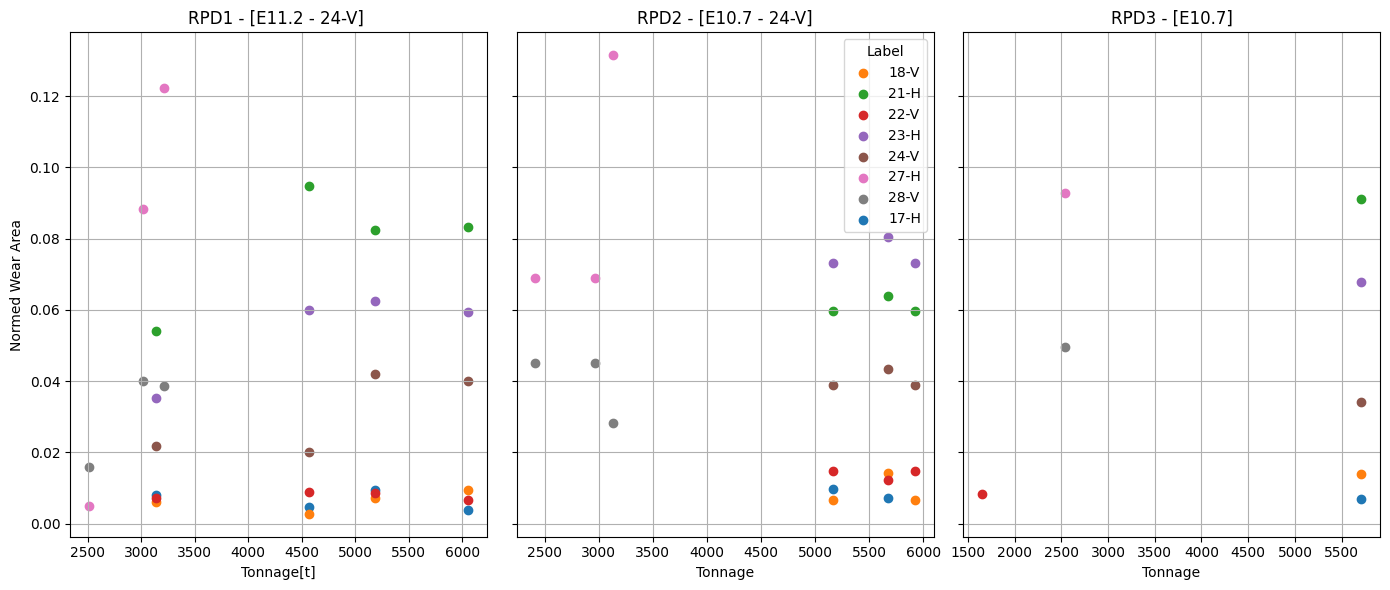

In [26]:
label_colors = {}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, label in enumerate(sorted(set(d['label'] for d in wear_areas))):
    label_colors[label] = color_cycle[i % len(color_cycle)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
ax1.set_ylabel('Normed Wear Area')

for wear_dicts in wear_areas:
    if wear_dicts['groove'] == 'RPD1':
        ax1.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color=label_colors[wear_dicts['label']],
                    label=wear_dicts['label'])

ax1.set_title('RPD1 - [E11.2 - 24-V] ')
ax1.set_xlabel('Tonnage[t]')
ax1.grid()

for wear_dicts in wear_areas:
    if wear_dicts['groove'] == 'RPD2':
        ax2.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color=label_colors[wear_dicts['label']],
                    label=wear_dicts['label'])

ax2.set_title('RPD2 - [E10.7 - 24-V]')
ax2.set_xlabel('Tonnage')
ax2.grid()

for wear_dicts in wear_areas:
    if wear_dicts['groove'] == 'RPD3':
        ax3.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color=label_colors[wear_dicts['label']],
                    label=wear_dicts['label'])

ax3.set_title('RPD3 - [E10.7]')
ax3.set_xlabel('Tonnage')
ax3.grid()

handles2, labels2 = ax2.get_legend_handles_labels()
by_label2 = dict(zip(labels2, handles2))
ax2.legend(by_label2.values(), by_label2.keys(), title="Label")

plt.tight_layout()

In [27]:
values_rpd1 = []
values_rpd2 = []
values_rpd3 = []
for wear_dicts in wear_areas:
    if wear_dicts['groove'] == 'RPD1':
        values_rpd1.append(wear_dicts)
    if wear_dicts['groove'] == 'RPD2':
        values_rpd2.append(wear_dicts)
    if wear_dicts['groove'] == 'RPD3':
        values_rpd3.append(wear_dicts)
values = [values_rpd1, values_rpd2, values_rpd3]

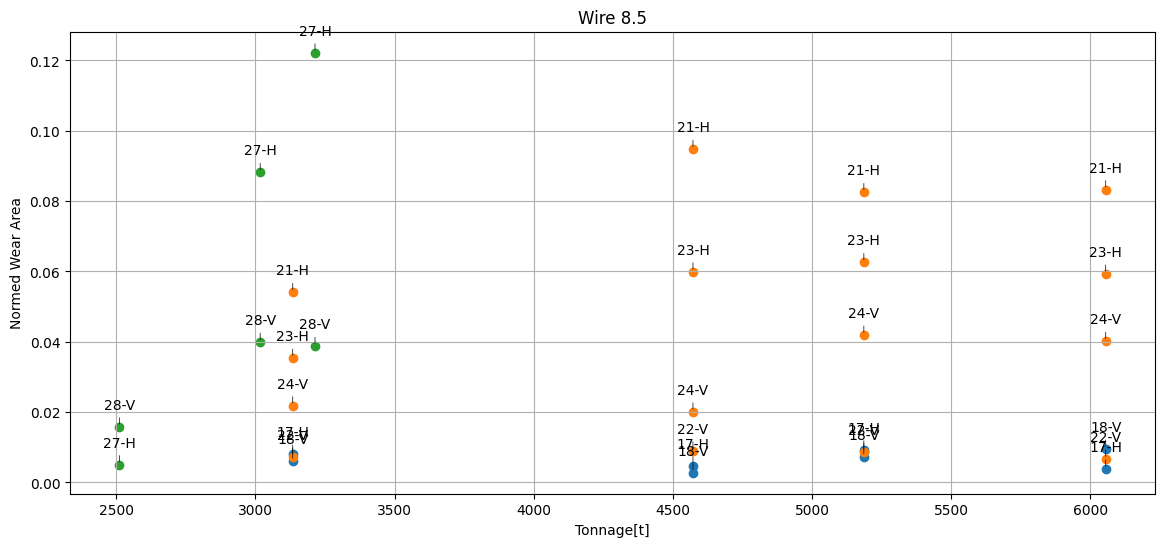

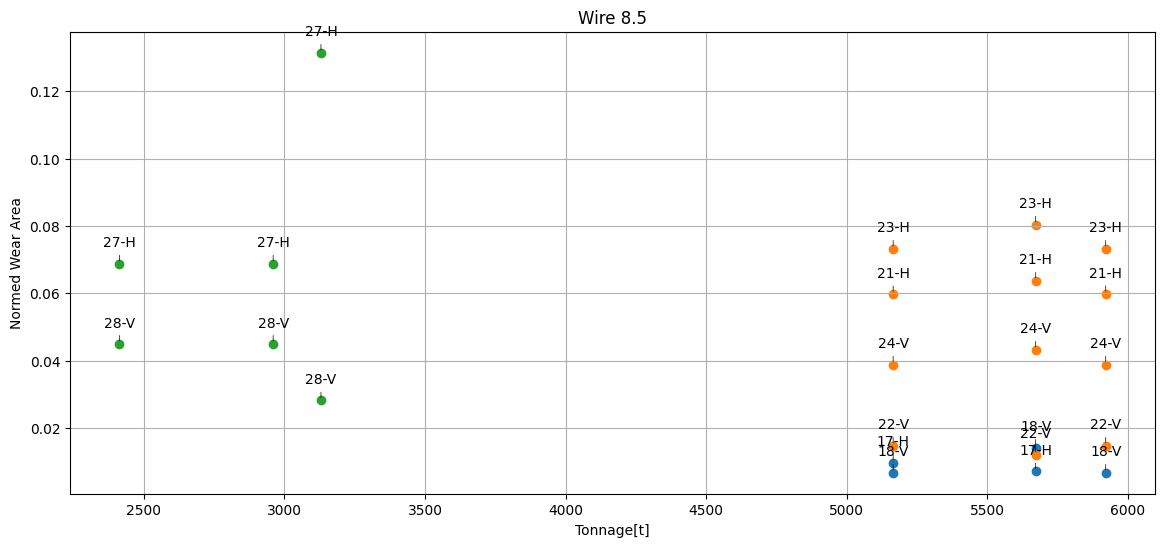

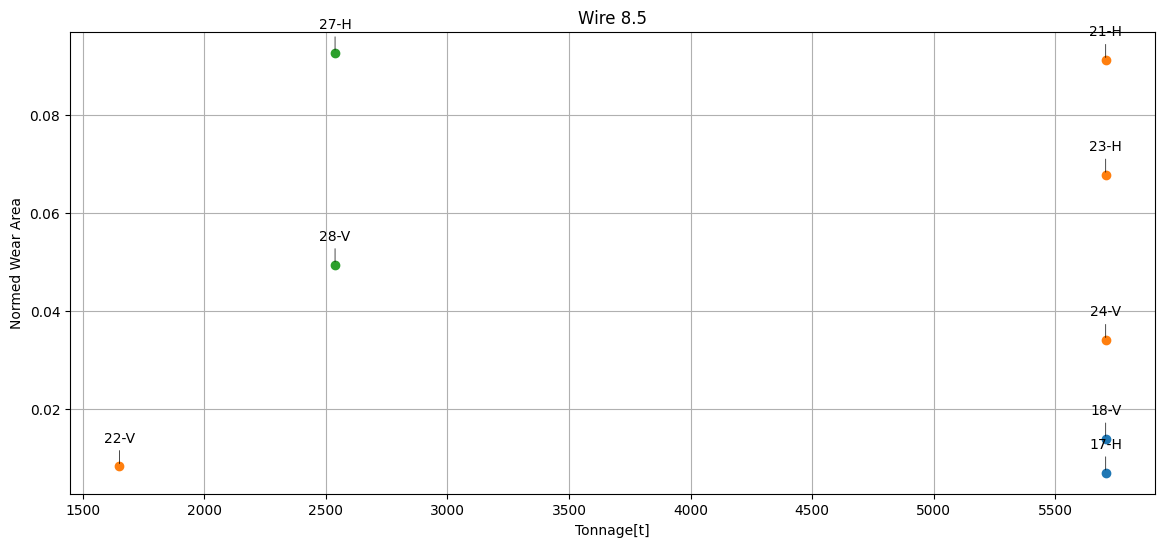

In [17]:
label_colors = {}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, label in enumerate(sorted(set(d['label'] for d in values_rpd1))):
    label_colors[label] = color_cycle[i % len(color_cycle)]

for value in values:
    fig, ax = plt.subplots(figsize=(14, 6))
    for wear_dicts in value:
        if wear_dicts['label'] in ["17-H", "18-V"]:
            ax.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color='C0', label=wear_dicts["label"])
            ax.annotate(
                wear_dicts["label"],
                xy=(wear_dicts['tonnage'], wear_dicts['normed_wear_area']),
                xytext=(wear_dicts['tonnage'], wear_dicts['normed_wear_area'] + 0.005),
                ha='center',
                fontsize=10,
                color='black',
                arrowprops=dict(arrowstyle='-', color='black', lw=0.5)
            )
        elif wear_dicts['label'] in ["21-H", "22-V", "23-H", "24-V"]:
            ax.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color='C1', label=wear_dicts["label"])
            ax.annotate(
                wear_dicts["label"],
                xy=(wear_dicts['tonnage'], wear_dicts['normed_wear_area']),
                xytext=(wear_dicts['tonnage'], wear_dicts['normed_wear_area'] + 0.005),
                ha='center',
                fontsize=10,
                color='black',
                arrowprops=dict(arrowstyle='-', color='black', lw=0.5)
            )
        if wear_dicts['label'] in ["27-H", "28-V"]:
            ax.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color='C2', label=wear_dicts["label"])
            ax.annotate(
                wear_dicts["label"],
                xy=(wear_dicts['tonnage'], wear_dicts['normed_wear_area']),
                xytext=(wear_dicts['tonnage'], wear_dicts['normed_wear_area'] + 0.005),
                ha='center',
                fontsize=10,
                color='black',
                arrowprops=dict(arrowstyle='-', color='black', lw=0.5)
            )

    ax.set_title('Wire 8.5')
    ax.set_xlabel('Tonnage[t]')
    ax.set_ylabel('Normed Wear Area')
    ax.grid()

In [31]:
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [37]:
normed_wear_areas = []
tonnages = []
for wear_dicts in wear_areas:
    normed_wear_areas.append(wear_dicts['normed_wear_area'])
    tonnages.append(wear_dicts['tonnage'])
normed_wear_areas_array = np.array(normed_wear_areas)
tonnages_array = np.array(tonnages)

data = np.array(list(zip(tonnages, normed_wear_areas, ))).reshape(len(tonnages), 2)

In [38]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(data)

    distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / data.shape[0])

    inertias.append(kmeanModel.inertia_)

    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

Distortion values:
1 : 1725708.6621680562
2 : 208040.60056097104
3 : 86138.96121402962
4 : 44762.0619105269
5 : 36309.43597797054
6 : 12426.665485680413
7 : 2598.279829289815
8 : 1388.7018325462138
9 : 585.9000430946603


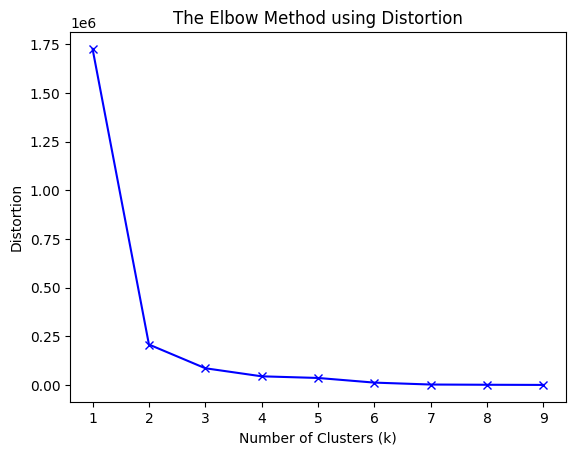

In [39]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Inertia values:
1 : 105268228.39225146
2 : 12690476.634219237
3 : 5254476.634055807
4 : 2730485.7765421416
5 : 2214875.594656204
6 : 758026.5946265052
7 : 158495.06958667876
8 : 84710.81178531902
9 : 35739.90262877429


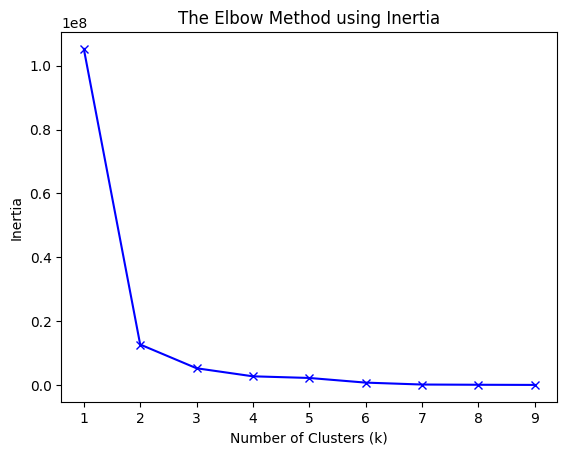

In [40]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

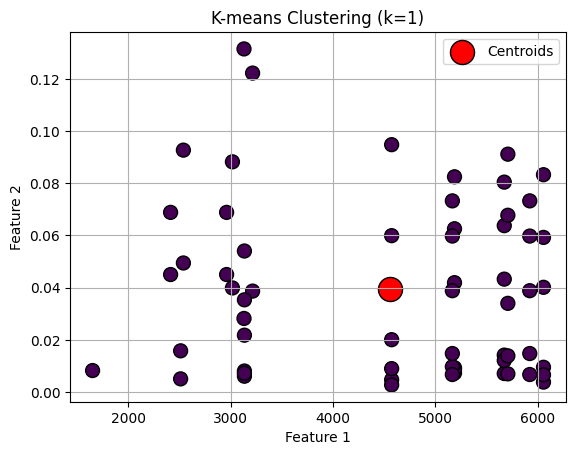

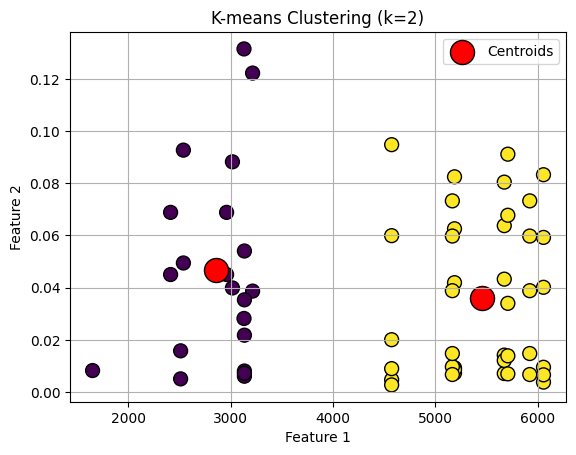

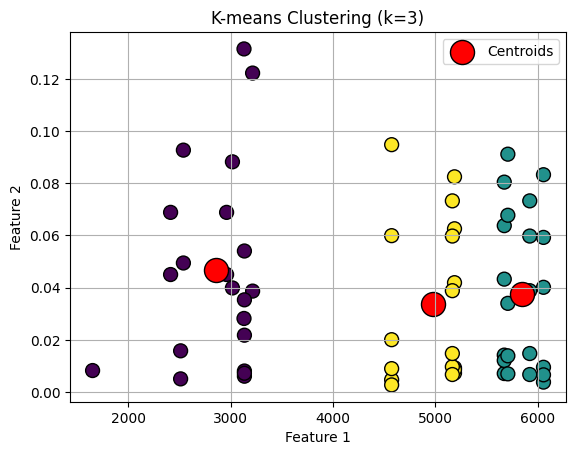

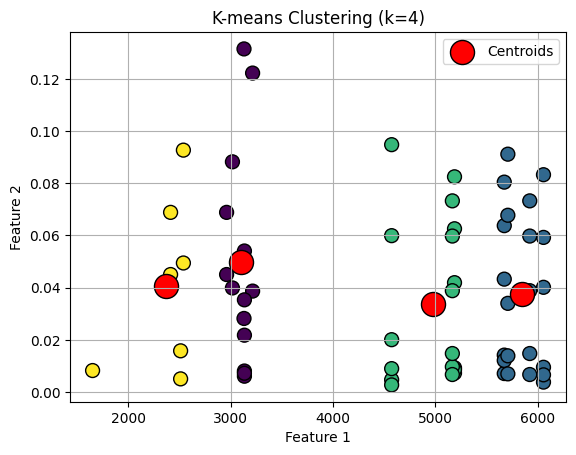

In [41]:
k_range = range(1, 5)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    y_kmeans = kmeans.fit_predict(data)

    plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, cmap='viridis', marker='o', edgecolor='k', s=100)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=300, c='red', label='Centroids', edgecolor='k')
    plt.title(f'K-means Clustering (k={k})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid()
    plt.show()